In [2]:
import xarray as xr
import numpy as np
import importlib
from matplotlib import pyplot as plt
import DA_core as DA
from glob import glob
import torch.utils.data as Data
from torch import optim
import torch
from torchsummary import summary
import ML_core as ML
from numpy.random import default_rng
import os
from scipy.interpolate import griddata

rng = default_rng()
DA.read_data_dir='/scratch/cimes/feiyul/PyQG/data/training'
DA.save_data_dir='/scratch/cimes/feiyul/PyQG/data/training'
data_dir='/scratch/cimes/feiyul/PyQG/data'
# data_dir='/net2/fnl/PyQG/data'
B_ens_kws={'cmap':'bwr','levels':np.linspace(-2.5E-11,2.5E-11,26),'extend':'both'}
B_ens_kws1={'cmap':'bwr','levels':np.linspace(-0.25E-11,0.25E-11,26),'extend':'both'}
q_kws={'cmap':'bwr','levels':np.linspace(-3.4E-5,3.4E-5,18),'extend':'both'}

INFO:  Logger initialized


In [ ]:
importlib.reload(ML)

In [ ]:
os.system('echo $HOSTNAME')
os.system('nvidia-smi')

In [ ]:
torch.cuda.device_count()

In [16]:
DA_paras={'nens':1280,
          'DA_method':'EnKF',
          'Nx_DA':32,
          'Nx_truth':128,
          'obs_freq':10,
          'obs_err':[1,-5,5,-7],
          'DA_freq':10,
          'save_B':False,
          'nobs':[50,50],
          'R_W':100,
          'inflate':[1,0.45]}
DA_exp=DA.DA_exp(**DA_paras)
print(DA_exp.file_name())
# obs_ds=DA_exp.read_obs()
in_ch=[0,1]
out_ch=[0,1,2]

EnKF_Nx32_from_Nx128_ens1280_freq10_relax0.45_R100_nobs50_50_err1E-5_5E-7


In [17]:
mean_ds=DA_exp.read_mean().load()
print(mean_ds.q.shape)
# if DA_exp.nens>1:  
#     std_ds=DA_exp.read_std()

# B_ens_ds=xr.open_mfdataset(['{}/{}/B_ens_day{:04d}.nc'.format(data_dir,DA_exp.file_name(),day) for day in np.arange(9,3650,10)])
B_ens_ds=xr.open_dataset('{}/training/{}/B_ens.nc'.format(data_dir,DA_exp.file_name()))
print(B_ens_ds.B_ens.shape)

ml_std_ds=xr.open_dataset('./ML/{0}/std_{0}.nc'.format(DA_exp.file_name()))
print(ml_std_ds)

B_R=int((len(B_ens_ds.x_d)-1)/2)
B_size=16
B_start=0

DA_days=slice(369,3650,DA_exp.DA_freq)
DA_it=slice(int((DA_days.start-DA_exp.DA_freq+1)/DA_exp.DA_freq),int((DA_days.stop-DA_exp.DA_freq+1)/DA_exp.DA_freq)+1)
i_x=np.arange(0,DA_exp.Nx_DA)
i_y=np.arange(0,DA_exp.Nx_DA)

/scratch/cimes/feiyul/PyQG/data/training/EnKF/EnsMean_EnKF_Nx32_from_Nx128_ens1280_freq10_relax0.45_R100_nobs50_50_err1E-5_5E-7.nc
(3650, 2, 32, 32)
(365, 2, 32, 32, 2, 17, 17)
<xarray.Dataset>
Dimensions:  (lev: 2)
Coordinates:
  * lev      (lev) int64 1 2
Data variables:
    B_std    (lev, lev) float64 ...
    q_std    (lev) float64 ...


In [18]:
B_shape=B_ens_ds.B_ens.isel(time=DA_it,y=i_y,x=i_x).shape
print(B_shape)
print(mean_ds.q.isel(time=DA_days).shape)
B_nt=B_shape[0]
B_ny=B_shape[2]
B_nx=B_shape[3]
B_total=B_nt*B_ny*B_nx
print(B_total)
n_train=int(B_total*0.8)
# rngs=rng.permutation(B_total)
rngs=np.arange(B_total)
partition={'train':rngs[DA_exp.Nx_DA*DA_exp.Nx_DA*2:n_train],'valid':rngs[n_train:]}
        
train_ds=ML.Dataset(mean_ds.q.isel(time=DA_days),DA_exp.Nx_DA,
                    B_ens_ds.B_ens.isel(time=DA_it,y=i_y,x=i_x),i_y,i_x,
                    partition['train'],ml_std_ds.q_std.data,ml_std_ds.B_std.data,
                    in_ch,out_ch,B_size=B_size,B_start=B_start)
valid_ds=ML.Dataset(mean_ds.q.isel(time=DA_days),DA_exp.Nx_DA,
                    B_ens_ds.B_ens.isel(time=DA_it,y=i_y,x=i_x),i_y,i_x,
                    partition['valid'],ml_std_ds.q_std.data,ml_std_ds.B_std.data,
                    in_ch,out_ch,B_size=B_size,B_start=B_start)

params = {'batch_size':128,'num_workers':1,'shuffle':True}
training_generator = torch.utils.data.DataLoader(train_ds, **params)
validation_generator = torch.utils.data.DataLoader(valid_ds, **params)

(329, 2, 32, 32, 2, 17, 17)
(329, 2, 32, 32)
336896


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features=32
Ulevels=2
if Ulevels==3:
    model=ML.Unet(in_ch=len(in_ch),out_ch=len(out_ch),features=features)
elif Ulevels==2:
    model=ML.Unet_2L(in_ch=len(in_ch),out_ch=len(out_ch),features=features)
model=model.to(device)
print(device)

# check keras-like model summary using torchsummary
summary(model, input_size=(len(in_ch),train_ds.B_size,train_ds.B_size))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             608
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           9,248
              ReLU-4           [-1, 32, 16, 16]               0
         MaxPool2d-5             [-1, 32, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]          18,496
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
              ReLU-9             [-1, 64, 8, 8]               0
        MaxPool2d-10             [-1, 64, 4, 4]               0
           Conv2d-11            [-1, 128, 4, 4]          73,856
             ReLU-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 128, 4, 4]         147,584
             ReLU-14            [-

In [20]:
model=model.double()
DA_train={'nens':1280,
          'DA_method':'EnKF',
          'Nx_DA':32,
          'Nx_truth':128,
          'obs_freq':10,
          'obs_err':[1,-5,5,-7],
          'DA_freq':10,
          'save_B':False,
          'nobs':[50,50],
          'R_W':100,
          'inflate':[1,0.45]}
DA_train_exp=DA.DA_exp(**DA_train)
epoch=105
B_size_training=16
model_file='./ML/{}/{}L{}f/unet_epoch{}_in{}_out{}_B{}_{}.pt'.format(
    DA_train_exp.file_name(),Ulevels,features,epoch,''.join(map(str,in_ch)),
    ''.join(map(str,out_ch)),B_size_training,DA_train_exp.file_name())
print(model_file)
model.load_state_dict(torch.load(model_file))
model.to(device)
model.eval()

ml_std_ds_training=xr.open_dataset('./ML/{0}/std_{0}.nc'.format(DA_train_exp.file_name()))


./ML/EnKF_Nx32_from_Nx128_ens1280_freq10_relax0.45_R100_nobs50_50_err1E-5_5E-7/2L32f/unet_epoch105_in01_out012_B16_EnKF_Nx32_from_Nx128_ens1280_freq10_relax0.45_R100_nobs50_50_err1E-5_5E-7.pt


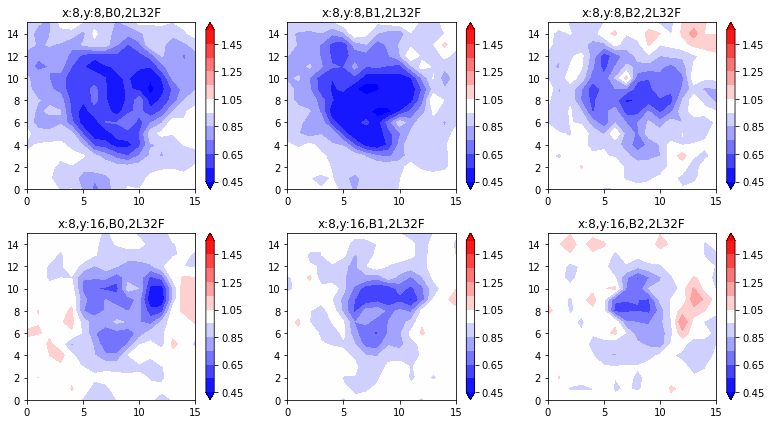

In [25]:
fig,axes=plt.subplots(2,3,figsize=(11,6))
DA_days=slice(369,3650,DA_exp.DA_freq)
DA_it=slice(int((DA_days.start-DA_exp.DA_freq+1)/DA_exp.DA_freq),int((DA_days.stop-DA_exp.DA_freq+1)/DA_exp.DA_freq)+1)
# cov_3dvar=xr.open_dataset('/scratch/cimes/feiyul/PyQG/data/B_Nx32_100years_2lev.nc')
# cov_static=np.zeros((3,16,16))
B_radius=8
B_size=B_radius*2
B_training_radius=8
B_training_size=B_training_radius*2
B_skip=0

for i_x,x in enumerate([8]):
    for i_y,y in enumerate([8,16]):
        i_h=i_x*3+i_y
        # for j in range(-8,8):
        #     for i in range(-8,8):
        #         cov_static[0,j+8,i+8]=cov_3dvar.cov[(y+j)*32+(x+i),(y+j)*32+(x+i)]
        #         cov_static[1,j+8,i+8]=cov_3dvar.cov[(y+j)*32+(x+i)+1024,(y+j)*32+(x+i)]
        #         cov_static[2,j+8,i+8]=cov_3dvar.cov[(y+j)*32+(x+i)+1024,(y+j)*32+(x+i)+1024]

        cov_enkf=np.zeros((len(B_ens_ds.B_ens.time.isel(time=DA_it)),3,B_size,B_size))
        cov_enkf[:,0,:,:]=B_ens_ds.B_ens.isel(time=DA_it,x=x,y=y,lev=0,lev_d=0).data[:,B_skip:B_size+B_skip,B_skip:B_size+B_skip]
        cov_enkf[:,1,:,:]=B_ens_ds.B_ens.isel(time=DA_it,x=x,y=y,lev=0,lev_d=1).data[:,B_skip:B_size+B_skip,B_skip:B_size+B_skip]
        cov_enkf[:,2,:,:]=B_ens_ds.B_ens.isel(time=DA_it,x=x,y=y,lev=1,lev_d=1).data[:,B_skip:B_size+B_skip,B_skip:B_size+B_skip]

        q=mean_ds.q.isel(time=DA_days,x=slice(x-B_training_radius,x+B_training_radius),
                         y=slice(y-B_training_radius,y+B_training_radius))
        if DA_train_exp.Nx_DA==DA_exp.Nx_DA:
            unet_input=torch.autograd.Variable(torch.from_numpy(
                q.data/ml_std_ds_training.q_std.data[None,:,None,None]).to(device))
        else:
            X_DA=np.arange(0,B_training_size)
            Y_DA=np.arange(0,B_training_size)
            X_DA_mesh,Y_DA_mesh=np.meshgrid(X_DA,Y_DA)
            X_training=np.arange(2,B_training_size-2,2)
            Y_training=np.arange(2,B_training_size-2,2)
            X_training_mesh,Y_training_mesh=np.meshgrid(X_training,Y_training)
            q_interp=griddata((X_DA_mesh.flatten(),Y_DA_mesh.flatten()),
                              q.data.reshape((q.data.shape[0]*q.data.shape[1],-1)).transpose(),
                              (X_training_mesh,Y_training_mesh),method='cubic',fill_value=0.0)
            q_input=q_interp.transpose((2,0,1)).reshape((q.data.shape[0],q.data.shape[1],B_training_radius-2,B_training_radius-2))
            
            # q_input=0.5*0.5*q.data[:,:,2:-2:2,2:-2:2]+\
            #         0.5*0.25*(q.data[:,:,1:-3:2,2:-2:2]+q.data[:,:,3:-2:2,2:-2:2]+q.data[:,:,2:-2:2,1:-3:2]+q.data[:,:,2:-2:2,3:-2:2])+\
            #             0.25*0.25*(q.data[:,:,1:-3:2,1:-3:2]+q.data[:,:,1:-3:2,3:-2:2]+q.data[:,:,3:-2:2,1:-3:2]+q.data[:,:,3:-2:2,3:-2:2])
            
            unet_input=torch.autograd.Variable(torch.from_numpy(
                q_input/ml_std_ds_training.q_std.data[None,:,None,None]).to(device))
            
        cov_pred=model(unet_input).to('cpu').detach().numpy() 
        
        if DA_train_exp.Nx_DA==DA_exp.Nx_DA:
            cov_unet=cov_pred
        else:
            X_training=np.arange(2,B_training_size-2,2)
            Y_training=np.arange(2,B_training_size-2,2)
            X_training_mesh,Y_training_mesh=np.meshgrid(X_training,Y_training)
            X_DA=np.arange(6,B_size+7)
            Y_DA=np.arange(6,B_size+7)
            X_DA_mesh,Y_DA_mesh=np.meshgrid(X_DA,Y_DA)
            data_interp=griddata((X_training_mesh.flatten(),Y_training_mesh.flatten()),
                                cov_pred.reshape((cov_pred.shape[0]*cov_pred.shape[1],-1)).transpose(),
                                (X_DA_mesh,Y_DA_mesh),method='cubic',fill_value=0.0)
            cov_unet=data_interp[0:B_size,0:B_size,:].transpose((2,0,1)).reshape((cov_pred.shape[0],cov_pred.shape[1],B_size,B_size))
            print(cov_unet.shape)
            
        cov_unet[:,0,:,:]=cov_unet[:,0,:,:]*ml_std_ds_training.B_std.data[0,0]
        cov_unet[:,1,:,:]=cov_unet[:,1,:,:]*ml_std_ds_training.B_std.data[1,0]
        cov_unet[:,2,:,:]=cov_unet[:,2,:,:]*ml_std_ds_training.B_std.data[1,1]

        cov_enkf_norm=cov_enkf/np.mean(cov_enkf[:,:,B_radius,B_radius],0)[None,:,None,None]
        cov_unet_norm=cov_unet/np.mean(cov_unet[:,:,B_radius,B_radius],0)[None,:,None,None]
        
        cov_std=np.sqrt(np.mean((cov_enkf_norm-np.mean(cov_enkf_norm,0)[None,:,:,:])*(cov_enkf_norm-np.mean(cov_enkf_norm,0)[None,:,:,:]),0))
        mse_unet=np.sqrt(np.mean((cov_enkf_norm-cov_unet_norm)*(cov_enkf_norm-cov_unet_norm),0))
        for i in range(3):
            hc=axes[i_h,i].contourf(mse_unet[i,:,:]/cov_std[i,:,:],cmap='bwr',
                                    levels=np.linspace(0.45,1.55,12),extend='both')
            plt.colorbar(hc,ax=axes[i_h,i])
            axes[i_h,i].set_title('x:{},y:{},B{},{}L{}F'.format(x,y,i,Ulevels,features))

fig.tight_layout()
fig.savefig('./plots/Nx{}_ens{}_UNet_epoch{}_Nx{}_ens{}_{}L_{}f.png'.format(
    DA_exp.Nx_DA,DA_exp.nens,epoch,DA_train_exp.Nx_DA,DA_train_exp.nens,Ulevels,features))

torch.Size([128, 2, 16, 16])
(128, 3, 16, 16)


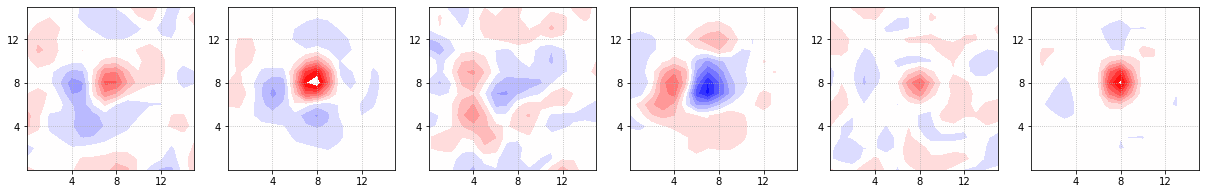

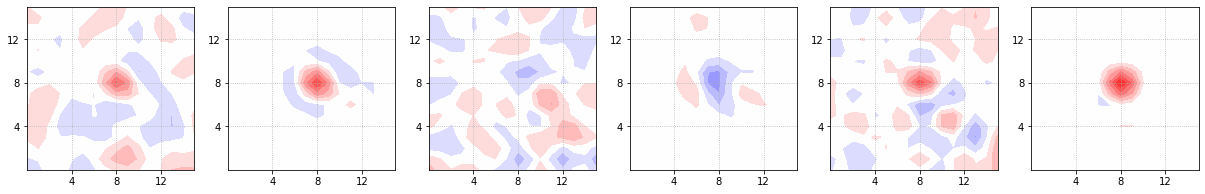

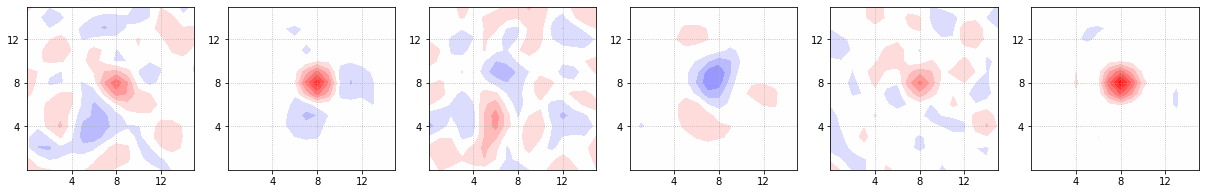

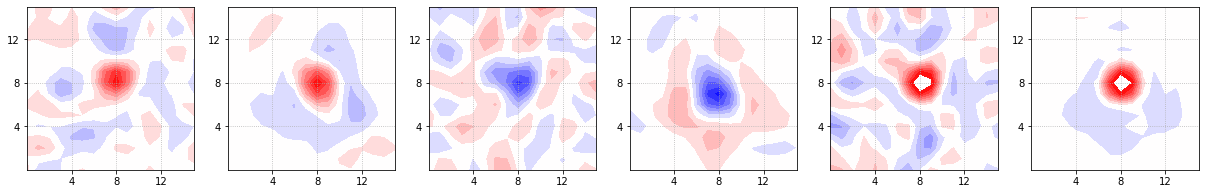

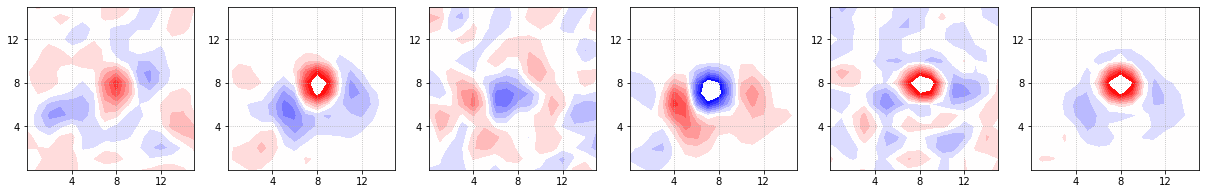

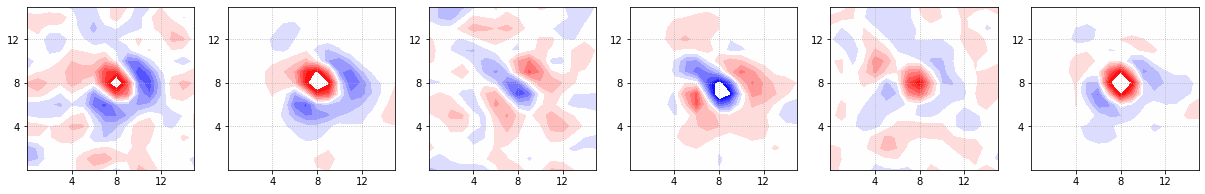

In [12]:
B_radius=8
B_size=B_radius*2
B_training_radius=8
B_training_size=B_training_radius*2

batch_x,batch_y=next(iter(validation_generator))
print(batch_x.shape)
# batch_x,batch_y=next(iter(training_generator))
if DA_train_exp.Nx_DA==DA_exp.Nx_DA:
    b_x = torch.autograd.Variable(batch_x.to(device)) # Inputs
else:
    X_DA=np.arange(4,B_size+4)
    Y_DA=np.arange(4,B_size+4)
    X_DA_mesh,Y_DA_mesh=np.meshgrid(X_DA,Y_DA)
    X_training=np.arange(2,B_training_size-2,2)
    Y_training=np.arange(2,B_training_size-2,2)
    X_training_mesh,Y_training_mesh=np.meshgrid(X_training,Y_training)
    x_data=batch_x.numpy()
    # print(X_DA)
    # print(X_training)
    print(x_data.reshape((x_data.shape[0]*x_data.shape[1],-1)).transpose().shape)
    x_interp=griddata((X_DA_mesh.flatten(),Y_DA_mesh.flatten()),
                        x_data.reshape((x_data.shape[0]*x_data.shape[1],-1)).transpose(),
                        (X_training_mesh,Y_training_mesh),method='cubic',fill_value=0.0)
    x_input=x_interp.transpose((2,0,1)).reshape((x_data.shape[0],x_data.shape[1],B_training_radius-2,B_training_radius-2))
    b_x=torch.autograd.Variable(torch.from_numpy(x_input).to(device))
    
b_y = torch.autograd.Variable(batch_y.to(device)) # outputs

prediction = model(b_x)

if DA_train_exp.Nx_DA==DA_exp.Nx_DA:
    B_pred=prediction.to('cpu').detach().numpy()
else:
    X_training=np.arange(2,B_training_size-2,2)
    Y_training=np.arange(2,B_training_size-2,2)
    X_training_mesh,Y_training_mesh=np.meshgrid(X_training,Y_training)
    X_DA=np.arange(6,B_size+7)
    Y_DA=np.arange(6,B_size+7)
    X_DA_mesh,Y_DA_mesh=np.meshgrid(X_DA,Y_DA)
    B_data=prediction.to('cpu').detach().numpy()
    data_interp=griddata((X_training_mesh.flatten(),Y_training_mesh.flatten()),
                        B_data.reshape((B_data.shape[0]*B_data.shape[1],-1)).transpose(),
                        (X_DA_mesh,Y_DA_mesh),method='cubic',fill_value=0.0)
    B_pred=data_interp[0:B_size,0:B_size,:].transpose((2,0,1)).reshape((B_data.shape[0],B_data.shape[1],B_size,B_size))
            
print(B_pred.shape)

B_batch=batch_y
q_batch=batch_x

for i_day in np.arange(0,30,5):
    fig,axes=plt.subplots(1,6,figsize=(21,3))
    for ax,data_field in zip(axes,[B_batch[i_day,0,...],B_pred[i_day,0,...],
                                   B_batch[i_day,1,...],B_pred[i_day,1,...],
                                   B_batch[i_day,2,...],B_pred[i_day,2,...]]):
        im=ax.contourf(data_field,cmap='bwr',levels=np.linspace(-7.5,7.5,16))
        ax.set_xticks(np.arange(4,train_ds.B_size,4).astype(np.int_))
        ax.set_yticks(np.arange(4,train_ds.B_size,4).astype(np.int_))
        ax.grid(linestyle=':')
        # plt.colorbar(im,ax=ax)